In [1]:
import sys
import os
import warnings
os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import pyarrow.parquet as pq
import pyarrow as pa
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
LOCAL_DATA_PATH = './context_data/'
SPLIT_SEED = 42
DATA_FILE = 'competition_data_final_pqt'
TARGET_FILE = 'public_train.pqt'
SUBMISSION_FILE = 'submit.pqt'

In [4]:
id_to_submit = pq.read_table(f'{LOCAL_DATA_PATH}/{SUBMISSION_FILE}').to_pandas()

In [5]:
# pqf = pq.ParquetFile(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd = pq.ParquetDataset(f'{LOCAL_DATA_PATH}/{DATA_FILE}')
pqd.files

['./context_data//competition_data_final_pqt/part-00000-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00001-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00002-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00003-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00004-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00005-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00006-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00007-aba60f69-2b63-4cc1-95ca-542598094698-c000.snappy.parquet',
 './context_data//competition_data_final_pqt/part-00008-aba60f69-2b63-4cc1-95ca-

In [7]:
data_agg = None
for ifile in pqd.files :

    #data = pq.read_table(f'{LOCAL_DATA_PATH}/{DATA_FILE}/{ifile}')
    data = pq.read_table(f'{ifile}')
    #pd.DataFrame([(z.name, z.type) for z in data.schema], columns = [['field', 'type']])

    data_agg0 = data.select(['user_id', 'url_host', 'request_cnt']).\
        group_by(['user_id', 'url_host']).aggregate([('request_cnt', "sum")])
    
    if data_agg is None :
        data_agg = data_agg0
        #print(data_agg.to_pandas().count)
    else :
        data_agg = pa.concat_tables([data_agg,data_agg0],promote=False)
    
    del data, data_agg0

In [8]:
data_agg.to_pandas().info

<bound method DataFrame.info of           request_cnt_sum  user_id                        url_host
0                      12    45098                   ad.adriver.ru
1                     491    45098                       apple.com
2                     174    45098          avatars.mds.yandex.net
3                     305    45098     googleads.g.doubleclick.net
4                     446    45098                     i.ytimg.com
...                   ...      ...                             ...
32277664                1   300964                     youtube.com
32277665                1   300964                     biosfera.kz
32277666                1   300964  chihuahuadog-ru.turbopages.org
32277667                1   300964             sun9-88.userapi.com
32277668                2   300964                      showjet.ru

[32277669 rows x 3 columns]>

Регион   
, населенный пункт   
, производиель устройства   
, модель устроства   
, домен, с которого пришел рекламный запрос   
, тип устройства (смартфон или что-то другое)   
, операционка на устройстве   
, оценка цены устройства   
, дата   
, время дня (утро, вечер ...)   
, число запросов   
, id пользователя   

In [11]:
#df = data.to_pandas()
#df.head()

In [12]:
#df.info(), df.describe()

In [13]:
#data.select(['cpe_type_cd']).to_pandas()['cpe_type_cd'].value_counts()

In [14]:
targets = pq.read_table(f'{LOCAL_DATA_PATH}/{TARGET_FILE}')
pd.DataFrame([(z.name, z.type) for z in targets.schema], columns = [['field', 'type']])

,field,type
0,age,double
1,is_male,string
2,user_id,int64
3,__index_level_0__,int64


In [15]:
data_agg.to_pandas().describe()

,request_cnt_sum,user_id
count,3.227767e+07,3.227767e+07
mean,1.724852e+01,2.074424e+05
std,6.242678e+01,1.200214e+05
min,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.037680e+05
50%,2.000000e+00,2.077030e+05
75%,8.000000e+00,3.116840e+05
max,3.938000e+03,4.153160e+05


In [16]:
url_set = set(data_agg.select(['url_host']).to_pandas()['url_host'])
print(f'{len(url_set)} urls')
url_dict = {url: idurl for url, idurl in zip(url_set, range(len(url_set)))}
usr_set = set(data_agg.select(['user_id']).to_pandas()['user_id'])
print(f'{len(usr_set)} users')
usr_dict = {usr: user_id for usr, user_id in zip(usr_set, range(len(usr_set)))}

199683 urls
415317 users


In [17]:
import faiss

In [48]:
%%time
values = np.array(data_agg.select(['request_cnt_sum']).to_pandas()['request_cnt_sum'])
rows = np.array(data_agg.select(['user_id']).to_pandas()['user_id'].map(usr_dict))
cols = np.array(data_agg.select(['url_host']).to_pandas()['url_host'].map(url_dict))
mat = scipy.sparse.coo_matrix((values, (rows, cols)), shape=(rows.max() + 1, cols.max() + 1))
als = implicit.approximate_als.FaissAlternatingLeastSquares(factors = 250, iterations = 30, use_gpu = False, \
       calculate_training_loss = False, regularization = 0.1)

CPU times: user 7.45 s, sys: 604 ms, total: 8.05 s
Wall time: 7.99 s


In [64]:
als.model.__dict__

{'item_factors': array([[0.00712771, 0.00499195, 0.00736313, ..., 0.00491015, 0.00650969,
         0.00315168],
        [0.00662548, 0.00756913, 0.0041724 , ..., 0.00330202, 0.00600855,
         0.00431066],
        [0.0032476 , 0.00469976, 0.00402464, ..., 0.00608568, 0.00209814,
         0.00815242],
        ...,
        [0.0061027 , 0.00091225, 0.00678619, ..., 0.00602314, 0.0076422 ,
         0.00656484],
        [0.00527387, 0.00522061, 0.00633023, ..., 0.00171991, 0.00327895,
         0.00402438],
        [0.00496071, 0.00705086, 0.00805795, ..., 0.00370551, 0.00419046,
         0.00232848]], dtype=float32),
 'user_factors': array([[ 0.78614104, -0.1274568 ,  0.02779923, ...,  0.49079466,
         -0.13413249, -0.51985383],
        [ 1.1374131 , -0.7486666 , -0.8622989 , ...,  1.1876624 ,
          0.23439668, -0.5151153 ],
        [ 0.98142064, -0.42097905, -0.1771358 , ...,  0.8294704 ,
         -0.20803368, -0.46906695],
        ...,
        [ 0.0421448 , -0.01057772, -0.01362

In [50]:
%%time
als.fit(mat)
u_factors = als.model.user_factors 
d_factors = als.model.item_factors

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 52min 37s, sys: 10 s, total: 52min 47s
Wall time: 6min 56s


## Получим оценку по полу

In [51]:
%%time
inv_usr_map = {v: k for k, v in usr_dict.items()}
usr_emb = pd.DataFrame(u_factors)
usr_emb['user_id'] = usr_emb.index.map(inv_usr_map)
usr_targets = targets.to_pandas()
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['is_male'] != 'NA']
df = df.dropna()
df['is_male'] = df['is_male'].map(int)
df['is_male'].value_counts()

CPU times: user 2.41 s, sys: 292 ms, total: 2.7 s
Wall time: 2.69 s


1    135331
0    128994
Name: is_male, dtype: int64

In [52]:
%%time
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], test_size = 0.33, random_state = SPLIT_SEED)
clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(f'GINI по полу {2 * m.roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]) - 1:2.3f}')

GINI по полу 0.669
CPU times: user 7min 51s, sys: 13.6 s, total: 8min 5s
Wall time: 1min 5s


In [53]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['is_male'], verbose = False)
id_to_submit['is_male'] = clf.predict_proba(id_to_submit.merge(usr_emb, how = 'inner', on = ['user_id']))[:,1]

## Получим оценку по возрасту

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline
sns.set_style('darkgrid')

In [55]:
def age_bucket(x):
    return bisect.bisect_left([18,25,35,45,55,65], x)

<AxesSubplot:xlabel='age', ylabel='Count'>

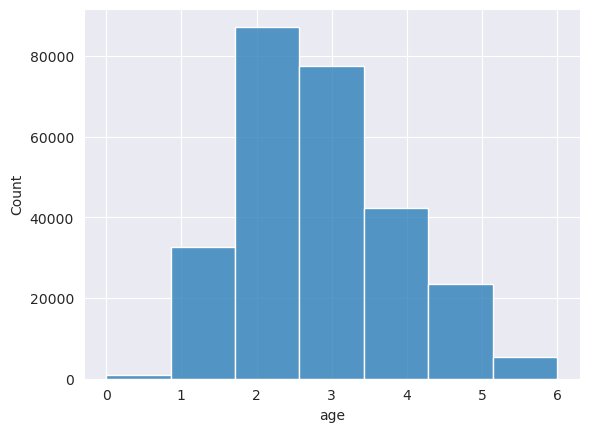

In [56]:
df = usr_targets.merge(usr_emb, how = 'inner', on = ['user_id'])
df = df[df['age'] != 'NA']
df = df.dropna()
df['age'] = df['age'].map(age_bucket)
sns.histplot(df['age'], bins = 7)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

              precision    recall  f1-score   support

         <18       0.00      0.00      0.00       349
       18-25       0.51      0.30      0.38     10663
       25-34       0.48      0.62      0.54     28815
       35-44       0.40      0.52      0.45     25791
       45-54       0.36      0.20      0.26     13931
       55-65       0.41      0.19      0.26      7688
         65+       0.36      0.01      0.03      1849

    accuracy                           0.44     89086
   macro avg       0.36      0.26      0.27     89086
weighted avg       0.43      0.44      0.41     89086



x_train, x_test, y_train, y_test = train_test_split(\
    df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], test_size = 0.33, random_state = SPLIT_SEED)

clf = CatBoostClassifier()
clf.fit(x_train, y_train, verbose = False)
print(m.classification_report(y_test, clf.predict(x_test), \
                            target_names = ['<18', '18-25','25-34', '35-44', '45-54', '55-65', '65+']))

In [58]:
clf.fit(df.drop(['user_id', 'age', 'is_male'], axis = 1), df['age'], verbose = False)
id_to_submit['age'] = clf.predict(id_to_submit[['user_id']].merge(usr_emb, how = 'inner', on = ['user_id']))

## Сабмит

In [59]:
id_to_submit.head()

,user_id,is_male,age
221301,221301,0.976778,2
31271,31271,0.558827,3
211594,211594,0.493528,2
253119,253119,0.532796,2
192578,192578,0.866905,2


In [60]:
id_to_submit.to_csv(f'{LOCAL_DATA_PATH}/submission2.csv', index = False)

In [61]:
! head $LOCAL_DATA_PATH/submission1.csv

user_id,is_male,age
221301,0.9523721503994212,2
31271,0.540058202285835,3
211594,0.4921148361193288,2
253119,0.5031936669434278,2
192578,0.7343094598406392,2
268458,0.28223318330597313,2
205507,0.5256998725263032,3
341343,0.6329608219845485,3
282144,0.026135216529779966,2


# Скор на лидерборде

In [32]:
context_scorer(submission, answers)

NameError: name 'context_scorer' is not defined